In [28]:
# Least Squares using states expressed as excitations relative to a nuclear ground state
import csv
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv

In [39]:
# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()

# extract the SPEs and TBME's for the background (n50em) interaction
backgroundHam = energyDF[0,6:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# do the same for the fitted interaction from BAB
fittedHam = energyDF[1,6:75]

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,1]
error = energyDF[2:,3]

# extract a matrix of the beta coefficients in each energy contribution for the Hamiltonian
betas = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    for j in range(len(backgroundHam)):
        if exp[i] <= 0:
            betas[i,j] = energyDF[i+2,j+6]
            gsContributions = betas[i,:]
        else:
            betas[i,j] = energyDF[i+2,j+6] - gsContributions[j]
    #print(betas[i])
#print(betas)
#print(energyDF[2:,4])
#print(scipy.linalg.norm(energyDF[2:,4]-exp)/math.sqrt(len(exp)))

In [40]:
# Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
e = np.empty(len(backgroundHam))
G = np.empty((len(backgroundHam),len(backgroundHam)))
for i in range(len(backgroundHam)):           # Contructing data vector (e)
    eTot = 0
    for k in range(len(exp)):
        eTot += (exp[k]*betas[k,i])/(error[k]**2)
    e[i] = eTot
for i in range(len(backgroundHam)):           # Constructing design matrix (G)
    for j in range(len(backgroundHam)):
        gTot = 0
        for k in range(len(exp)):
            gTot += (betas[k,i]*betas[k,j])/(error[k]**2)
        G[i,j] = gTot

In [41]:
# Here we perform an SVD of our design matrix and invert the singular values (in S)
# to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
U, Svec, Ut = np.linalg.svd(G)
# Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
# e and p into new vectors c and y, respectively
c = np.dot(Ut,e)
y = np.dot(Ut,backgroundHam)

35 vlc eRMS = 0.10902740935240546  pRMS =  0.24788430514059545
full SVD eRMS = 0.07037470581002099  pRMS = 1.0129288238908243


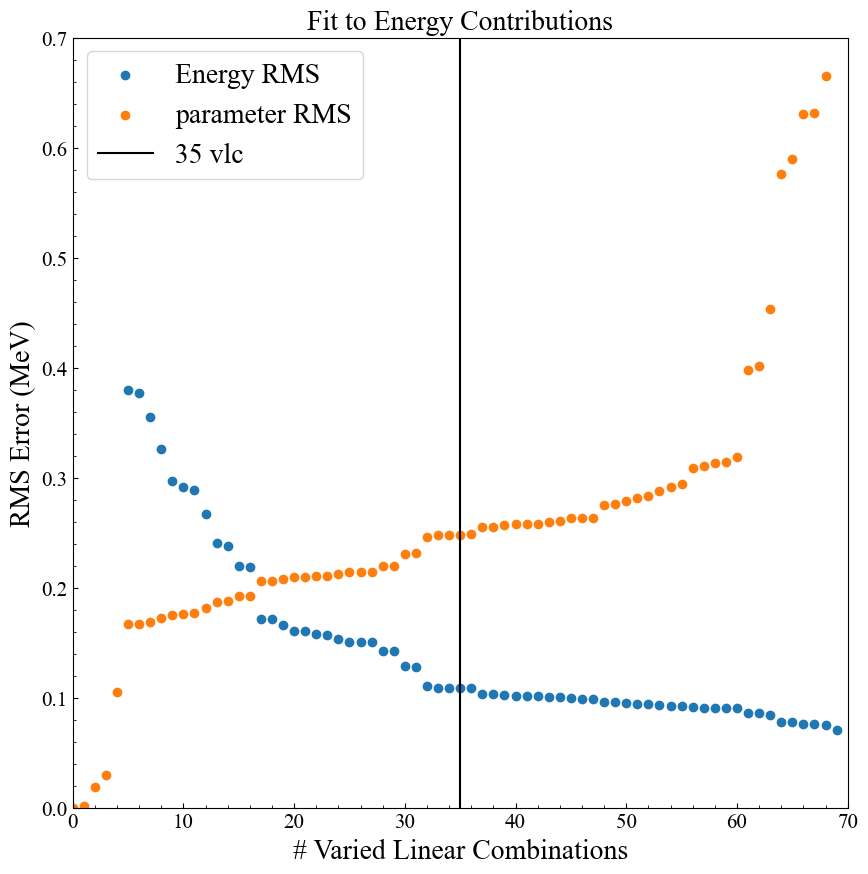

In [42]:
# This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
# at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
pRMS = np.empty(len(Svec)+1)
for i in range(len(backgroundHam)+1):
    yfit = np.zeros(len(backgroundHam))
    fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
    fitEnergies = np.empty(len(exp))                    # Array for storing fitted energies in this iteration
    for j in range(len(backgroundHam)):
        if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
            yfit[j] = c[j]/Svec[j]
        elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
            yfit[j] = y[j]
    fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
    for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
        fitEnergies[j] = eFitTot
    eResidual = exp - fitEnergies
    pResidual = backgroundHam - fitParameters
    eRMS[i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
    pRMS[i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
print('35 vlc eRMS =', eRMS[34], ' pRMS = ', pRMS[34])
print('full SVD eRMS =', eRMS[69], ' pRMS =', pRMS[69])
x = [i for i in range(len(eRMS))]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter(x, eRMS, label='Energy RMS')
plt.scatter(x, pRMS, label='parameter RMS')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('Fit to Energy Contributions',fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in")
plt.legend(loc=2,fontsize=20)
plt.show()

In [43]:
# Fit using a handwritten least-squares solution to the minimization problem
Ginv = inv(G)
pfinal = np.dot(Ginv,e)
newHam = np.empty(len(backgroundHam))
pRes = pfinal-backgroundHam
eRes = np.empty(0)
for j in range(len(exp)):
        if error[j] <= 1.0:
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += pfinal[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            eRes = np.append(eRes, eFitTot - exp[j])
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))


least squares energy RMS = 0.07037470581002096
least squares parameter RMS = 1.012928823465107


In [46]:
# Least squares solution using numpy linalg as a check that my least squares solution agrees
newExp = np.empty(len(exp))
M = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    newExp[i] = exp[i]/error[i]
    for j in range(len(backgroundHam)):
        M[i,j] = betas[i,j]/error[i]
lstSq = np.linalg.lstsq(M, newExp, rcond=None)
lsHam = lstSq[0]
#print(lstSq[0])                    # This is the set of weights which minimizes least squares for the energy contributions
lsEnergy = np.empty(len(exp))
eRes = np.empty(0)
for j in range(len(exp)):
        if error[j] <= 1.0:
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += lsHam[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            eRes = np.append(eRes, exp[j]-eFitTot)
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))
pRes = lsHam-backgroundHam
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))
print(lsHam-fittedHam)                                  # Difference between BAB Hamiltonian and my least squares

least squares energy RMS = 0.07037470581002148
least squares parameter RMS = 1.012928823910232
[ 9.55748599e-05  2.47822563e-04 -2.10283354e-05  8.71794007e-06
 -3.22804954e-03 -5.26976718e-04  1.07341888e-03 -6.09047820e-03
  1.12819293e-03 -9.34904867e-04  6.43909135e-04  7.89094002e-04
  1.64095368e-03 -2.71379245e-03 -2.05587751e-04  4.34674561e-03
  6.08186571e-04 -1.16499271e-03  9.54190733e-04 -6.41066692e-04
 -1.50203322e-03  1.32730299e-03 -7.44713855e-03 -9.33790806e-04
 -1.44630516e-03 -6.65289019e-04  1.13090722e-03 -3.78457759e-04
  3.27174894e-04 -2.03462153e-04 -2.12365441e-04  1.70646659e-03
  2.49623573e-03 -8.25624444e-04  5.36970354e-04 -5.75619434e-04
 -3.56014280e-04  7.82604763e-04 -6.52044471e-04  1.92687328e-03
  8.23926664e-04 -8.32449374e-05  3.80450976e-03  7.92105134e-04
 -9.90176712e-04  2.96586033e-05  1.12388441e-05  1.01595838e-04
 -1.02388669e-03  8.43511168e-04 -2.35124988e-03  8.70337142e-04
  8.48558731e-05  6.86429748e-04 -7.27638555e-04 -2.78584661

In [47]:
outputs1 = np.array([exp, error, energyDF[2:,4], fitEnergies, energyDF[2:,4]-fitEnergies])
outputs2 = np.array([fittedHam, lsHam, lsHam-fittedHam])

with open("outputsBetas.dat","w") as f:
    f.write("Energy outputs   (0.189 MeV RMS for JP fit) \n")
    f.write("       exp      error        BAB         JP       Diff \n")
    np.savetxt(f, outputs1.T, delimiter=' ', fmt='%10.4f')
    f.write("Parameter outputs (0.616 MeV RMS for JP fit) \n")
    f.write("        BAB         JP       Diff \n")
    np.savetxt(f, outputs2.T, delimiter=' ', fmt='%10.4f')
    f.write("\n")
    f.write("Elements of G: \n")
    np.savetxt(f, G, delimiter=' ', fmt='%15.4f')

In [22]:
print(fittedHam)
print(lsHam)

[  0.     -14.8643 -14.239  -13.3503 -10.5378  -1.5159  -1.1826  -0.8045
  -1.1019   0.0702  -1.0718   0.7517   0.3935   0.9108  -2.4202  -0.02
  -0.6327   0.7452  -0.1363   0.3675  -0.7172  -1.5833   0.7391  -3.1045
   0.7971  -0.4134   1.1642  -0.5335  -0.4707  -0.0686   1.007   -1.0869
   0.5671   1.5916   0.3327  -0.8206   0.659    0.1487   0.8393  -0.6521
   1.3744   0.489    1.2548   0.3356   0.6161  -0.3758   0.4918   0.6381
  -3.9443   0.2225  -1.1854  -0.0408   0.6649   0.0269   0.5638  -0.0534
   0.6463   0.2372   1.7361   0.6329  -0.1694  -0.1143   0.2449   0.1191
   0.4237  -0.0592   1.0765   0.3896  -0.2783   0.5956]
[ -1.0000374  -14.86433012 -14.23900789 -13.35030493 -10.5377504
  -1.51600975  -1.18267279  -0.80442272  -1.10223034   0.07016118
  -1.07176533   0.75159026   0.39358263   0.91089438  -2.42043592
  -0.0201941   -0.6328659    0.74521448  -0.13644173   0.36753037
  -0.71711194  -1.58346595   0.7391077   -3.10501344   0.7971546
  -0.41366517   1.16407947  -0.533